In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

ohenc = OneHotEncoder()
lbenc = LabelEncoder()

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv('telecom_customer_churn.csv')

데이터 전처리

In [5]:
# offer : None
data['Offer'].fillna(value='None', inplace=True)

# Avg Monthly Long Distance Charges : 0
data['Avg Monthly Long Distance Charges'].fillna(value=0, inplace=True)

# Multiple Lines : No Phone Service
data['Multiple Lines'].fillna(value='No Phone Service', inplace=True)

# Avg Monthly GB Download : 0
data['Avg Monthly GB Download'].fillna(value=0, inplace=True)

# Q, S~Z : No Internet Service
recol_1 = data.columns[16]
data[recol_1].fillna(value='No Internet Service', inplace=True)

recol_2 = data.columns[18:26].tolist()
data[recol_2] = data[recol_2].fillna(value='No Internet Service')

# Churn C, R : None
recol_3 = data.columns[36:38].tolist()
data[recol_3] = data[recol_3].fillna(value='None')

In [6]:
# Joined 제거
data = data.drop(data[data['Customer Status'] == 'Joined'].index)

data['Customer Status'].head()

0     Stayed
1     Stayed
2    Churned
3    Churned
4    Churned
Name: Customer Status, dtype: object

In [7]:
dropc1 = ['Customer ID', 'City', 'Zip Code', 'Latitude', 'Longitude']
data = data.drop(dropc1, axis=1)

dropc2 = ['Churn Category', 'Churn Reason']
data = data.drop(dropc2, axis=1)

In [8]:
data['Customer Status'] = lbenc.fit_transform(data['Customer Status'])

for c in data.select_dtypes(include=['object']).columns:
  if len(data[c].unique()) == 2:
    data[c] = lbenc.fit_transform(data[c])
  else:
    data = pd.get_dummies(data, columns=[c], dtype=int)

In [9]:
dropc3 = ['Offer_None', 'Offer_Offer C', 'Offer_Offer D',
          'Multiple Lines_No', 'Multiple Lines_Yes',
          'Internet Type_Cable',
          'Device Protection Plan_Yes',
          'Streaming TV_Yes',
          'Streaming Movies_Yes',
          'Streaming Music_Yes',
          'Unlimited Data_No',
          'Payment Method_Mailed Check',
          'Gender',
          'Phone Service']
data = data.drop(dropc3, axis=1)

CatBoost

In [10]:
pip install catboost

In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score, auc

In [12]:
data.head()

,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Internet Service,Avg Monthly GB Download,Paperless Billing,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Offer_Offer A,Offer_Offer B,Offer_Offer E,Multiple Lines_No Phone Service,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_No Internet Service,Online Security_No,Online Security_No Internet Service,Online Security_Yes,Online Backup_No,Online Backup_No Internet Service,Online Backup_Yes,Device Protection Plan_No,Device Protection Plan_No Internet Service,Premium Tech Support_No,Premium Tech Support_No Internet Service,Premium Tech Support_Yes,Streaming TV_No,Streaming TV_No Internet Service,Streaming Movies_No,Streaming Movies_No Internet Service,Streaming Music_No,Streaming Music_No Internet Service,Unlimited Data_No Internet Service,Unlimited Data_Yes,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card
0,37,1,0,2,9,42.39,1,16.0,1,65.6,593.30,0.00,0,381.51,974.81,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1
1,46,0,0,0,9,10.69,1,10.0,0,-4.0,542.40,38.33,10,96.21,610.28,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,50,0,0,0,4,33.65,1,30.0,1,73.9,280.85,0.00,0,134.60,415.45,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0
3,78,1,0,1,13,27.82,1,4.0,1,98.0,1237.85,0.00,0,361.66,1599.51,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0
4,75,1,0,3,3,7.38,1,11.0,1,83.9,267.40,0.00,0,22.14,289.54,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1


In [63]:
data_v2 = data[['Tenure in Months', 'Number of Referrals',
       'Contract_Month-to-Month', 'Number of Dependents',
       'Monthly Charge', 'Age', 'Contract_Two Year', 'Total Revenue',
       'Internet Type_Fiber Optic', 'Total Charges',
       'Total Long Distance Charges', 'Premium Tech Support_No',
       'Avg Monthly Long Distance Charges', 'Online Security_No',
       'Payment Method_Credit Card', 'Avg Monthly GB Download', 'Married',
       'Streaming Music_No', 'Offer_Offer B', 'Paperless Billing',
       'Total Refunds', 'Total Extra Data Charges', 'Contract_One Year',
       'Streaming Movies_No', 'Online Backup_No',
       'Premium Tech Support_Yes', 'Streaming TV_No',
       'Payment Method_Bank Withdrawal', 'Device Protection Plan_No',
       'Internet Type_DSL', 'Offer_Offer E',
       'Unlimited Data_No Internet Service', 'Online Security_Yes',
       'Online Backup_Yes']]

In [64]:
data_v2.head()

,Tenure in Months,Number of Referrals,Contract_Month-to-Month,Number of Dependents,Monthly Charge,Age,Contract_Two Year,Total Revenue,Internet Type_Fiber Optic,Total Charges,Total Long Distance Charges,Premium Tech Support_No,Avg Monthly Long Distance Charges,Online Security_No,Payment Method_Credit Card,Avg Monthly GB Download,Married,Streaming Music_No,Offer_Offer B,Paperless Billing,Total Refunds,Total Extra Data Charges,Contract_One Year,Streaming Movies_No,Online Backup_No,Premium Tech Support_Yes,Streaming TV_No,Payment Method_Bank Withdrawal,Device Protection Plan_No,Internet Type_DSL,Offer_Offer E,Unlimited Data_No Internet Service,Online Security_Yes,Online Backup_Yes
0,9,2,0,0,65.6,37,0,974.81,0,593.30,381.51,0,42.39,1,1,16.0,1,1,0,1,0.00,0,1,1,0,1,0,0,1,0,0,0,0,1
1,9,0,1,0,-4.0,46,0,610.28,0,542.40,96.21,1,10.69,1,1,10.0,0,0,0,0,38.33,10,0,0,1,0,1,0,1,0,0,0,0,0
2,4,0,1,0,73.9,50,0,415.45,1,280.85,134.60,1,33.65,1,0,30.0,0,1,0,1,0.00,0,0,1,1,0,1,1,0,0,1,0,0,0
3,13,1,1,0,98.0,78,0,1599.51,1,1237.85,361.66,1,27.82,1,0,4.0,1,1,0,1,0.00,0,0,0,0,0,0,1,0,0,0,0,0,1
4,3,3,1,0,83.9,75,0,289.54,1,267.40,22.14,0,7.38,1,1,11.0,1,1,0,1,0.00,0,0,1,1,1,0,0,1,0,0,0,0,0


In [79]:
data_v3 = data[['Tenure in Months', 'Number of Dependents', 'Number of Referrals',
       'Contract_Month-to-Month', 'Monthly Charge', 'Age',
       'Contract_Two Year', 'Total Revenue', 'Total Charges',
       'Total Long Distance Charges', 'Online Security_No',
       'Avg Monthly Long Distance Charges', 'Premium Tech Support_No']]

In [80]:
data_v3.head()

,Tenure in Months,Number of Dependents,Number of Referrals,Contract_Month-to-Month,Monthly Charge,Age,Contract_Two Year,Total Revenue,Total Charges,Total Long Distance Charges,Online Security_No,Avg Monthly Long Distance Charges,Premium Tech Support_No
0,9,0,2,0,65.6,37,0,974.81,593.30,381.51,1,42.39,0
1,9,0,0,1,-4.0,46,0,610.28,542.40,96.21,1,10.69,1
2,4,0,0,1,73.9,50,0,415.45,280.85,134.60,1,33.65,1
3,13,0,1,1,98.0,78,0,1599.51,1237.85,361.66,1,27.82,1
4,3,0,3,1,83.9,75,0,289.54,267.40,22.14,1,7.38,0


In [94]:
data_v4 = data[['Tenure in Months', 'Number of Referrals',
       'Contract_Month-to-Month', 'Monthly Charge',
       'Number of Dependents']]

In [95]:
data_v4.head()

,Tenure in Months,Number of Referrals,Contract_Month-to-Month,Monthly Charge,Number of Dependents
0,9,2,0,65.6,0
1,9,0,1,-4.0,0
2,4,0,1,73.9,0
3,13,1,1,98.0,0
4,3,3,1,83.9,0


In [106]:
X = data.drop('Customer Status', axis=1)
y = data['Customer Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
rbsc = RobustScaler()
rb_xtrain = rbsc.fit_transform(X_train)
rb_xtest = rbsc.transform(X_test)

In [202]:
catb = CatBoostClassifier(verbose=0)

parameters_v1 = {
    'iterations': [10, 50, 100],
    'learning_rate': [0.1, 0.01],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

parameters_v2 = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.2, 0.1, 0.05],
    'depth': [3, 4, 5],
    'l2_leaf_reg': [0, 1, 2]
}

parameters_v3 = {
    'iterations': [80, 100, 120],
    'learning_rate': [0.1, 0.75, 0.05],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [0.5, 1, 1.5]
}

parameters_v4 = {
    'iterations': [10, 50, 100],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64],
    'random_strength': [0.1, 0.5],
    'bagging_temperature': [0.5, 1.0],
    'scale_pos_weight': [0.5, 1.0]
}

parameters_v5 = {
    'iterations': [100],
    'learning_rate': [0.1],
    'depth': [4],
    'l2_leaf_reg': [1],
    'border_count': [32, 64],
    'random_strength': [0.1, 0.5],
    'bagging_temperature': [0.5, 1.0],
    'scale_pos_weight': [0.5, 1.0]
}

In [203]:
catb_gs = GridSearchCV(catb, parameters_v5, cv=5, scoring='accuracy')
catb_gs.fit(rb_xtrain, y_train)

print("Best Parameters: ", catb_gs.best_params_)

Best Parameters:  {'bagging_temperature': 0.5, 'border_count': 64, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_strength': 0.1, 'scale_pos_weight': 1.0}


In [204]:
realcat = catb_gs.best_estimator_
realcat.fit(rb_xtrain, y_train)

In [205]:
y_pred = realcat.predict(rb_xtest)

In [206]:
accuracy_train = accuracy_score(y_train, realcat.predict(rb_xtrain))
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Churned', 'Stayed'])

In [207]:
y_proba = realcat.predict_proba(rb_xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

In [210]:
cvs = cross_val_score(realcat, X, y, cv=5)

train accuracy:  0.8996395370897363
test accuracy:  0.8748103186646434
F1 score:  0.9149922720247294
classification report: 
               precision    recall  f1-score   support

     Churned       0.85      0.69      0.76       383
      Stayed       0.88      0.95      0.91       935

    accuracy                           0.87      1318
   macro avg       0.87      0.82      0.84      1318
weighted avg       0.87      0.87      0.87      1318

ROC AUC:  0.9447983133438518


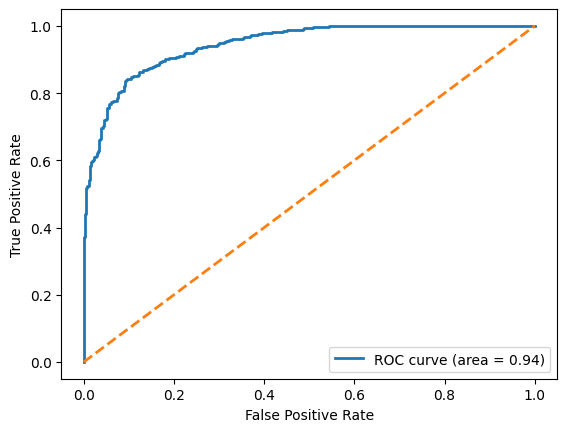

Cross Validation Scores:  [0.87253414 0.85660091 0.8861912  0.88467375 0.88382688]


In [211]:
print("train accuracy: ", accuracy_train)
print("test accuracy: ", accuracy)
print("F1 score: ", f1)
print("classification report: \n", report)
print("ROC AUC: ", roc_auc)

plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

print("Cross Validation Scores: ", cvs)

In [91]:
importances = realcat.feature_importances_
features = X.columns

importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_dfs = importances_df.sort_values(by='Importance', ascending=False)

importances_dfs

,Feature,Importance
0,Tenure in Months,21.759314
2,Number of Referrals,21.022331
3,Contract_Month-to-Month,17.168794
4,Monthly Charge,9.650806
1,Number of Dependents,9.058755
5,Age,4.943018
6,Contract_Two Year,3.936407
8,Total Charges,3.112837
12,Premium Tech Support_No,2.524668
10,Online Security_No,2.491440


In [93]:
im_data = importances_dfs[importances_dfs['Importance'] >= 5]
im_data['Feature'].values

array(['Tenure in Months', 'Number of Referrals',
       'Contract_Month-to-Month', 'Monthly Charge',
       'Number of Dependents'], dtype=object)

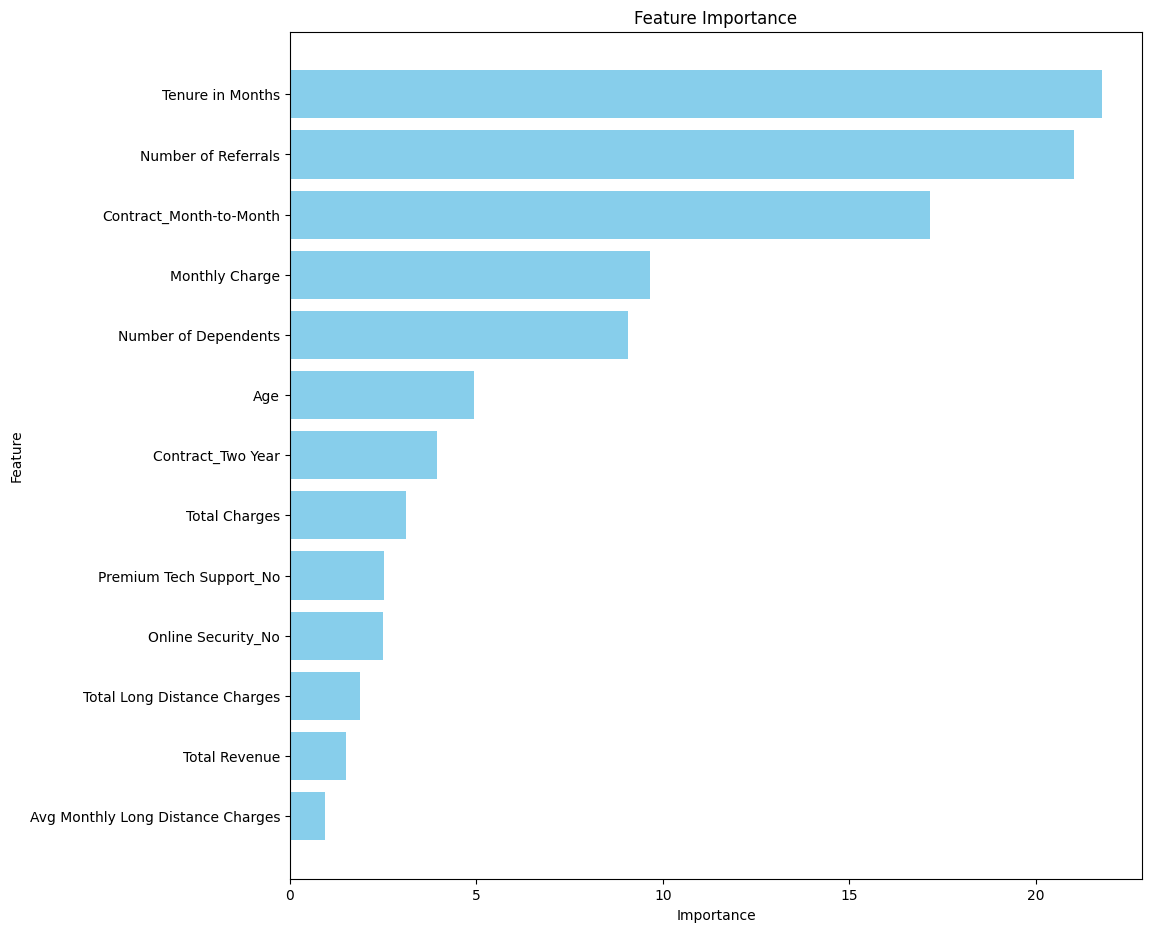

In [92]:
plt.figure(figsize=(11, 11))
plt.barh(importances_dfs['Feature'], importances_dfs['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()